In [ ]:
import torch
import normflows as nf
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader as dl
from torch.utils.data import TensorDataset as ds

In [ ]:
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
device

device(type='cuda')

In [ ]:
target = nf.distributions.TwoMoons()
base = nf.distributions.DiagGaussian(2)

In [ ]:
def data_loader_generator(number_of_samples,batchsize):
    data_points = target.sample(number_of_samples)
    target_data_set = ds(data_points)
    target_data_loader = dl(target_data_set,batch_size=batchsize,shuffle=True)
    return target_data_loader


In [ ]:
#Real NVP Model here
def Real_nvp_init():
    num_layers = 256
    Real_NVP_flows = []
    for i in range(num_layers):
        parameters = nf.nets.MLP([1,2],init_zeros=True)
        Real_NVP_flows.append(nf.flows.AffineCouplingBlock(param_map=parameters))
        Real_NVP_flows.append(nf.flows.Permute(2,mode="swap"))

    Real_NVP_model = nf.NormalizingFlow(q0=base,flows=Real_NVP_flows)

    return Real_NVP_model

In [ ]:
def MAF_init():
    MAF_flows = []
    hidden = 256 #number of hidden units
    
    latent_size = 2 #input dimensions
    
    K=8

    for i in range(K):
        MAF_flows += [nf.flows.MaskedAffineAutoregressive(latent_size, hidden)]
        MAF_flows += [nf.flows.Permute(2,mode="swap")]

    MAF_model = nf.NormalizingFlow(q0=base,flows=MAF_flows)

    return MAF_model

In [ ]:
#Neural Spline Flow
def Neural_Spline_Flow():
    K = 8
    torch.manual_seed(0)

    latent_size = 2
    hidden_units = 252
    hidden_layers = 2

    neural_flows = []
    for i in range(K):
        neural_flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
        neural_flows += [nf.flows.LULinearPermute(latent_size)]


    Neural_Spline_model= nf.NormalizingFlow(q0=base, flows=neural_flows)

    return Neural_Spline_model


In [ ]:
def RotationalQuadraticSpline_init():
    K = 7

    latent_size = 2
    hidden_units = 270
    hidden_layers = 2

    flows = []
    for i in range(K):
        flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
        flows += [nf.flows.LULinearPermute(latent_size)]

    # Set base distribution
    q0 = base
        
    # Construct flow model
    RotationalQuadraticSpline_model = nf.NormalizingFlow(q0, flows)

    return RotationalQuadraticSpline_model

In [ ]:
def train_model(model, target_data_loader,learning_rate):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
    tolerance = 0.0001
    previous_loss = float('inf')
    early_stop = False
    losses = []
    
    for epoch in range(1000):
        if not early_stop:
            model.train()
            for data in target_data_loader:
                optimizer.zero_grad()
                
                data = data[0].to(device)  # Extract data from TensorDataset and move to device
                loss = model.forward_kld(data)
                
                if ~(torch.isnan(loss) | torch.isinf(loss)):
                    loss.backward()
                    optimizer.step()
                
                current_loss = loss.item()
                
                if epoch > 0:
                    loss_diff = abs(current_loss - previous_loss)
                    if loss_diff < tolerance:
                        early_stop = True
                        print(f"Early stopping at epoch {epoch+1} with loss difference {loss_diff:.6f}")
                        break
                
                losses.append(loss.item())
                
                previous_loss = current_loss
    
    plt.figure()
    plt.plot(losses)
    plt.show()

    return model

  0%|          | 0/5 [00:00<?, ?it/s]

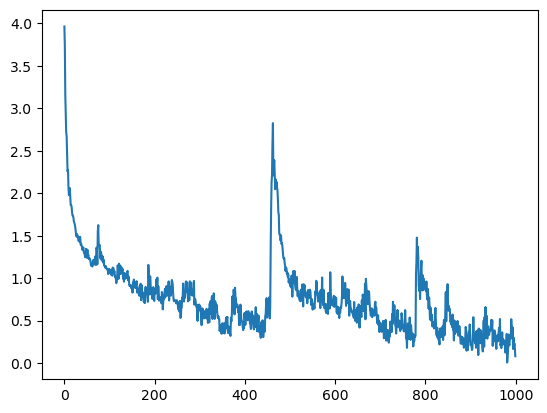

 20%|██        | 1/5 [01:53<07:33, 113.30s/it]

Early stopping at epoch 46 with loss difference 0.000063


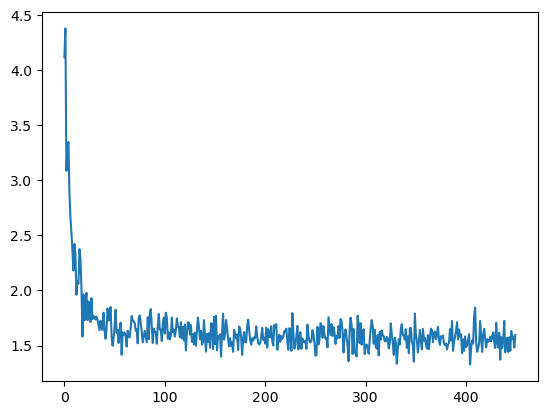

 40%|████      | 2/5 [02:34<03:32, 70.75s/it] 

Early stopping at epoch 34 with loss difference 0.000075


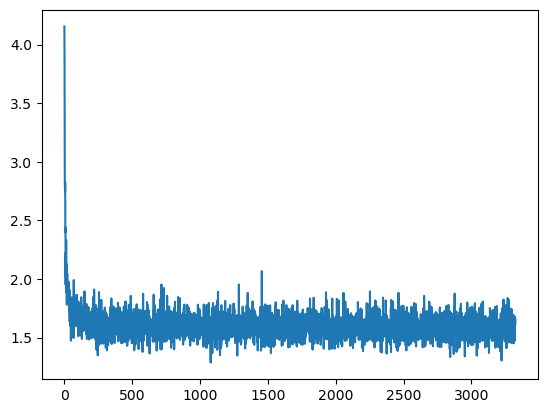

 60%|██████    | 3/5 [07:17<05:35, 167.83s/it]

Early stopping at epoch 2 with loss difference 0.000052


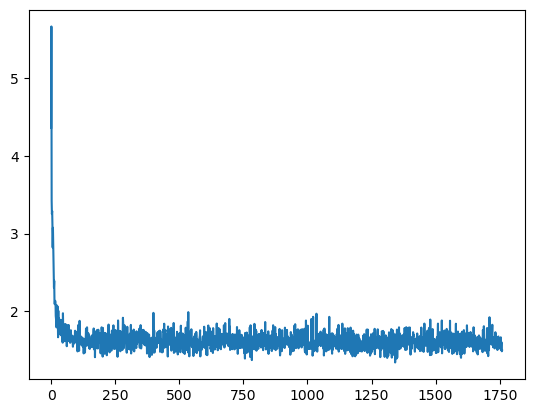

 80%|████████  | 4/5 [09:57<02:44, 164.51s/it]

Early stopping at epoch 2 with loss difference 0.000065


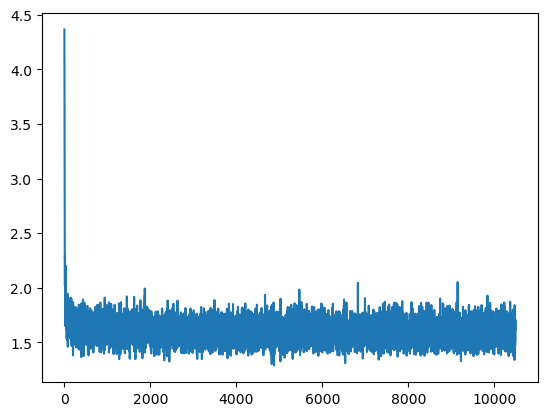

100%|██████████| 5/5 [24:42<00:00, 296.60s/it]


In [ ]:
#Neural Spline Flow Training
trained_Neural_Spline_models = []
sample_numbers = []

for numb in tqdm(range(2,7)):
        simple_models = Neural_Spline_Flow().to(device=device)
        number_of_samples = 10**numb
        batch_size = 100
        trained_Neural_Spline_models.append(train_model(model=simple_models,target_data_loader=data_loader_generator(number_of_samples=number_of_samples,batchsize=batch_size),learning_rate=0.0005))
        sample_numbers.append(number_of_samples)

  0%|          | 0/5 [00:00<?, ?it/s]

Early stopping at epoch 403 with loss difference 0.000051


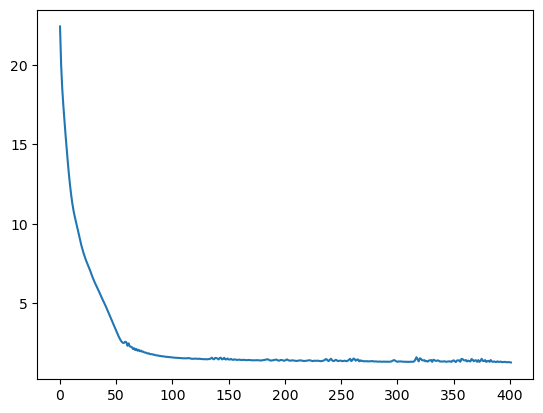

 20%|██        | 1/5 [00:10<00:41, 10.42s/it]

Early stopping at epoch 327 with loss difference 0.000062


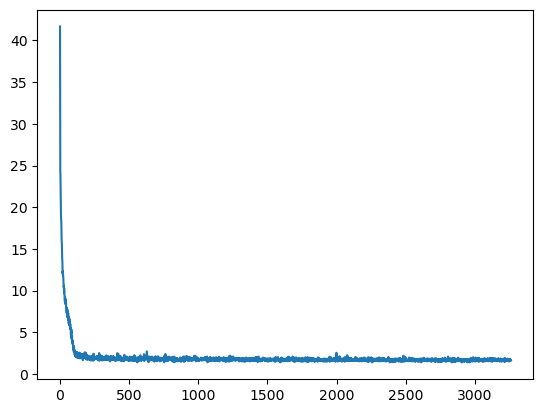

 40%|████      | 2/5 [01:27<02:29, 49.85s/it]

Early stopping at epoch 51 with loss difference 0.000093


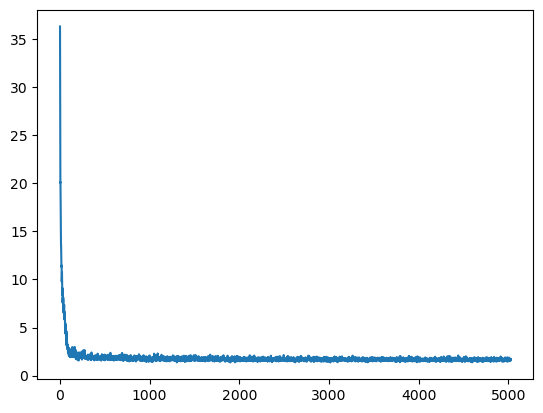

 60%|██████    | 3/5 [03:27<02:43, 81.61s/it]

Early stopping at epoch 4 with loss difference 0.000063


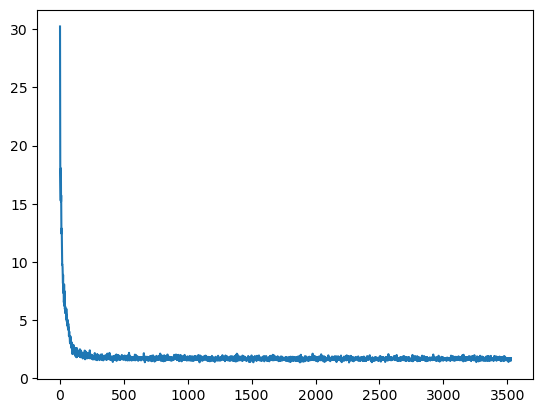

 80%|████████  | 4/5 [04:55<01:24, 84.25s/it]

Early stopping at epoch 2 with loss difference 0.000009


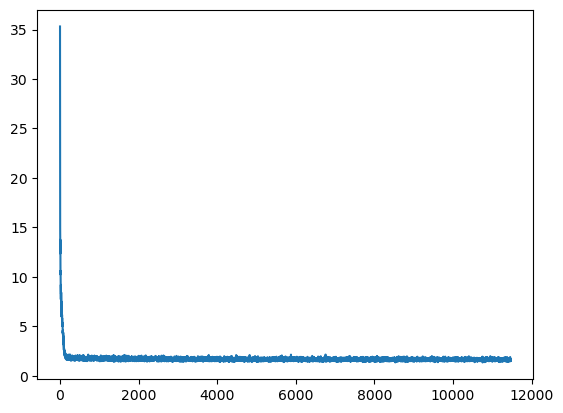

100%|██████████| 5/5 [09:18<00:00, 111.76s/it]


In [ ]:
#MAFtraining
trained_MAF_models = []
sample_numbers = []

for numb in tqdm(range(2,7)):
        simple_models = MAF_init().to(device=device)
        number_of_samples = 10**numb
        batch_size = 100
        trained_MAF_models.append(train_model(model=simple_models,target_data_loader=data_loader_generator(number_of_samples=number_of_samples,batchsize=batch_size),learning_rate=0.0001))
        sample_numbers.append(number_of_samples)

  0%|          | 0/5 [00:00<?, ?it/s]

Early stopping at epoch 224 with loss difference 0.000052


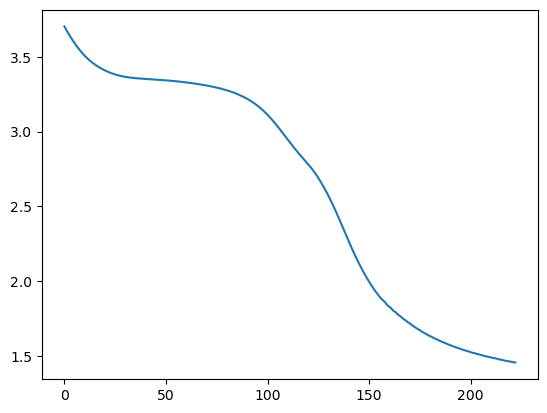

 20%|██        | 1/5 [00:53<03:33, 53.31s/it]

Early stopping at epoch 24 with loss difference 0.000067


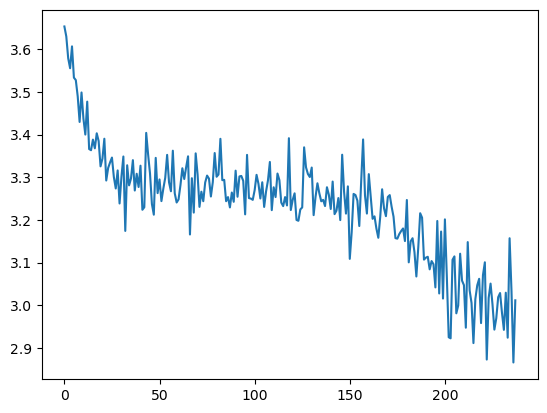

 40%|████      | 2/5 [01:47<02:42, 54.07s/it]

Early stopping at epoch 3 with loss difference 0.000001


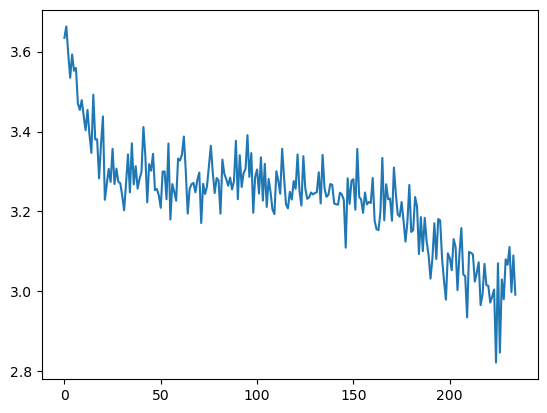

 60%|██████    | 3/5 [02:43<01:49, 54.67s/it]

Early stopping at epoch 4 with loss difference 0.000028


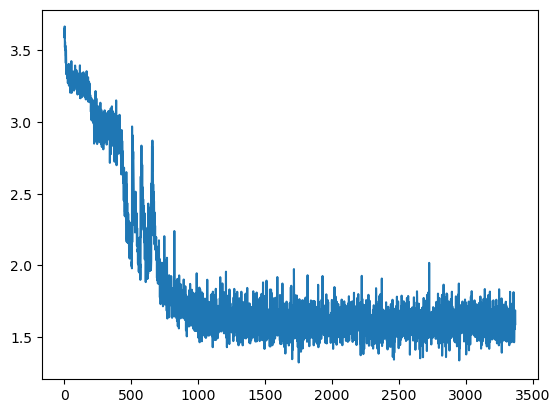

 80%|████████  | 4/5 [15:49<05:43, 343.48s/it]

Early stopping at epoch 2 with loss difference 0.000013


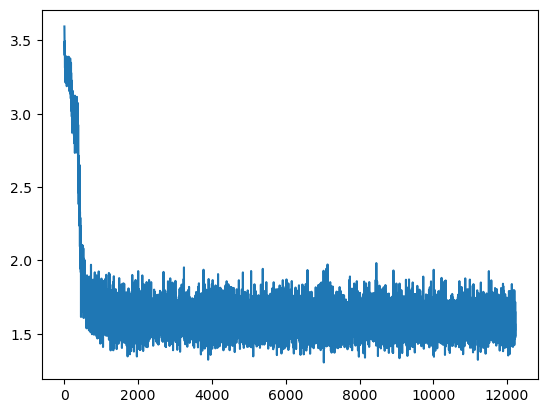

100%|██████████| 5/5 [1:03:10<00:00, 758.06s/it] 


In [ ]:
#RealNVPtraining
trained_Real_NVP_models = []
sample_numbers = []

for numb in tqdm(range(2,7)):
        simple_models = Real_nvp_init().to(device=device)
        number_of_samples = 10**numb
        batch_size = 100
        trained_Real_NVP_models.append(train_model(model=simple_models,target_data_loader=data_loader_generator(number_of_samples=number_of_samples,batchsize=batch_size),learning_rate=0.0001))
        sample_numbers.append(number_of_samples)

  0%|          | 0/5 [00:00<?, ?it/s]

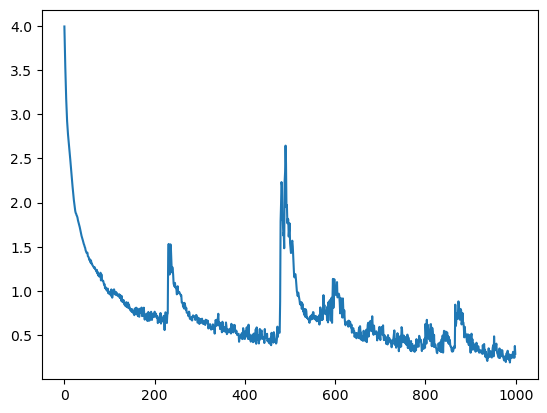

 20%|██        | 1/5 [01:09<04:38, 69.50s/it]

Early stopping at epoch 50 with loss difference 0.000004


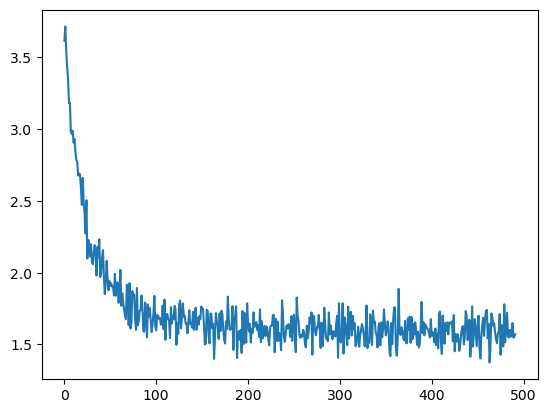

 40%|████      | 2/5 [01:43<02:26, 48.77s/it]

Early stopping at epoch 15 with loss difference 0.000040


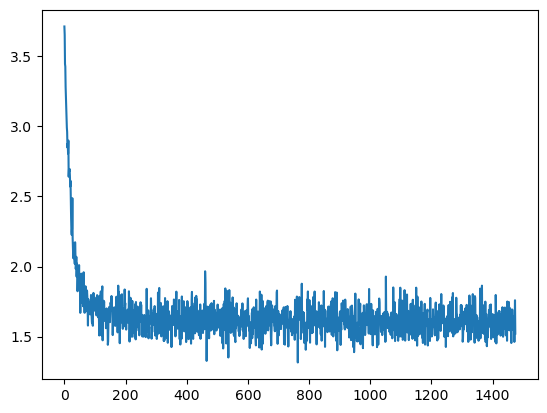

 60%|██████    | 3/5 [02:59<02:02, 61.05s/it]

Early stopping at epoch 10 with loss difference 0.000040


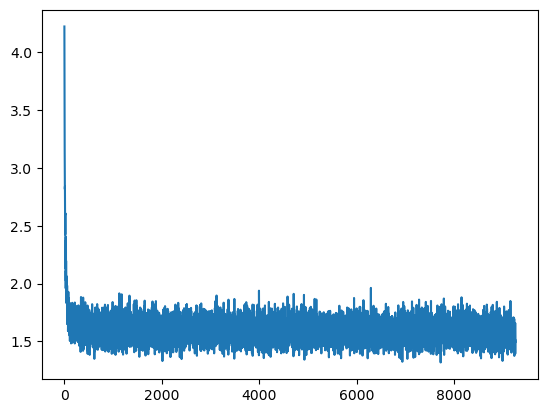

 80%|████████  | 4/5 [09:13<03:04, 184.68s/it]

Early stopping at epoch 2 with loss difference 0.000033


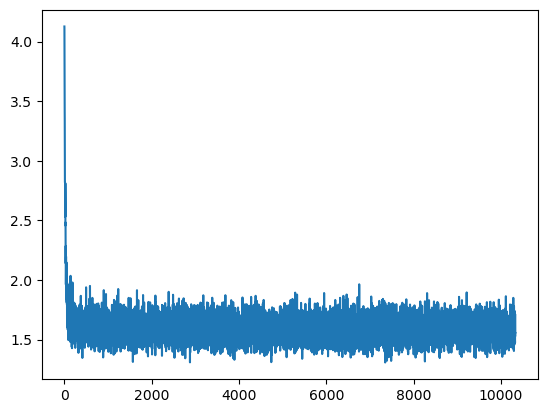

100%|██████████| 5/5 [16:15<00:00, 195.20s/it]


In [ ]:
#RotationalQuadraticSpline Training
trained_RotationalQuadraticSpline_models = []
sample_numbers = []

for numb in tqdm(range(2,7)):
        simple_models = RotationalQuadraticSpline_init().to(device=device)
        number_of_samples = 10**numb
        batch_size = 100
        trained_RotationalQuadraticSpline_models.append(train_model(model=simple_models,target_data_loader=data_loader_generator(number_of_samples=number_of_samples,batchsize=batch_size),learning_rate=0.0001))
        sample_numbers.append(number_of_samples)

In [ ]:
Models = [trained_Real_NVP_models,trained_Neural_Spline_models,trained_MAF_models,trained_RotationalQuadraticSpline_models]

In [ ]:
xgrid, ygrid = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-3, 3, 100))
target_probs = torch.exp(target.log_prob(torch.from_numpy(np.stack((xgrid, ygrid), axis=-1)).reshape((-1, 2)))).numpy().reshape((100, 100))

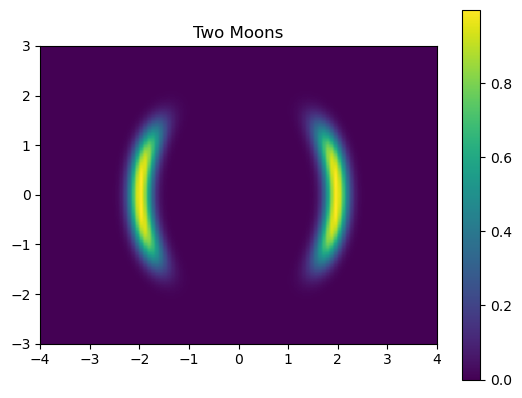

In [ ]:
plt.figure()
plt.imshow(target_probs, extent=(-4, 4, -3, 3))
plt.title('Two Moons')
plt.colorbar()
plt.show()

In [ ]:
trainable_parameters = []
for i in range(len(Models)):

    model_parameters = filter(lambda p: p.requires_grad, Models[i][1].parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])

    print(f'model has {params} trainable parameters')
    trainable_parameters.append(params)

model has 2187204 trainable parameters
model has 2139396 trainable parameters
model has 2119716 trainable parameters
model has 2141738 trainable parameters


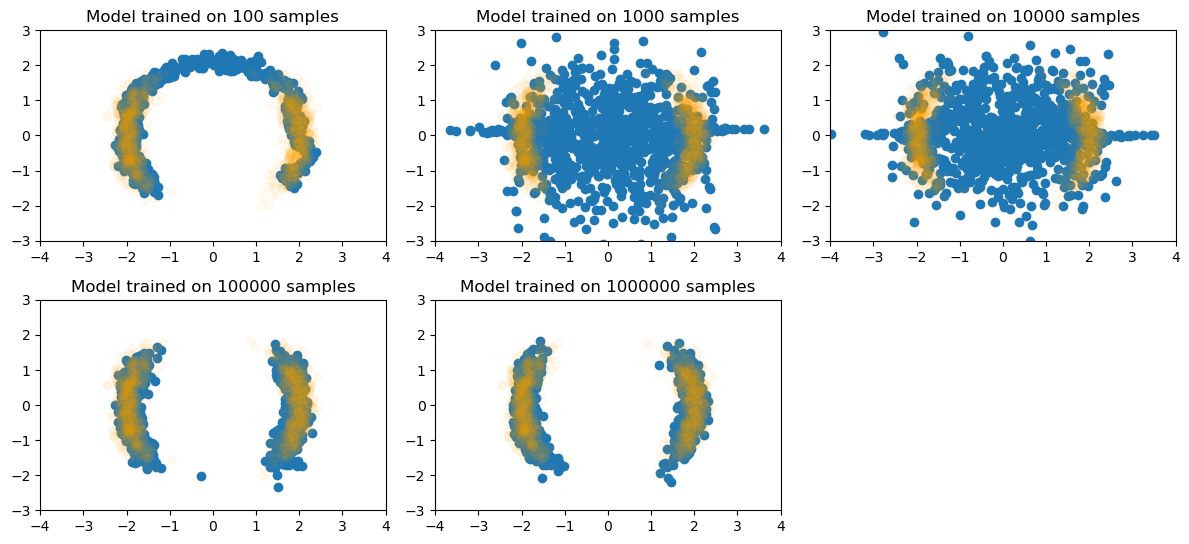

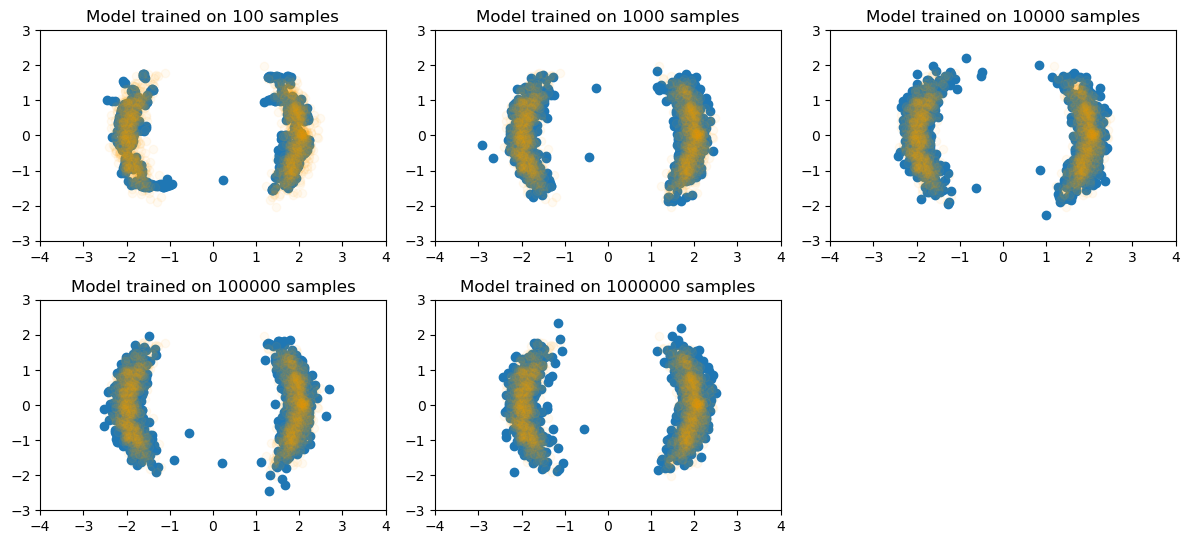

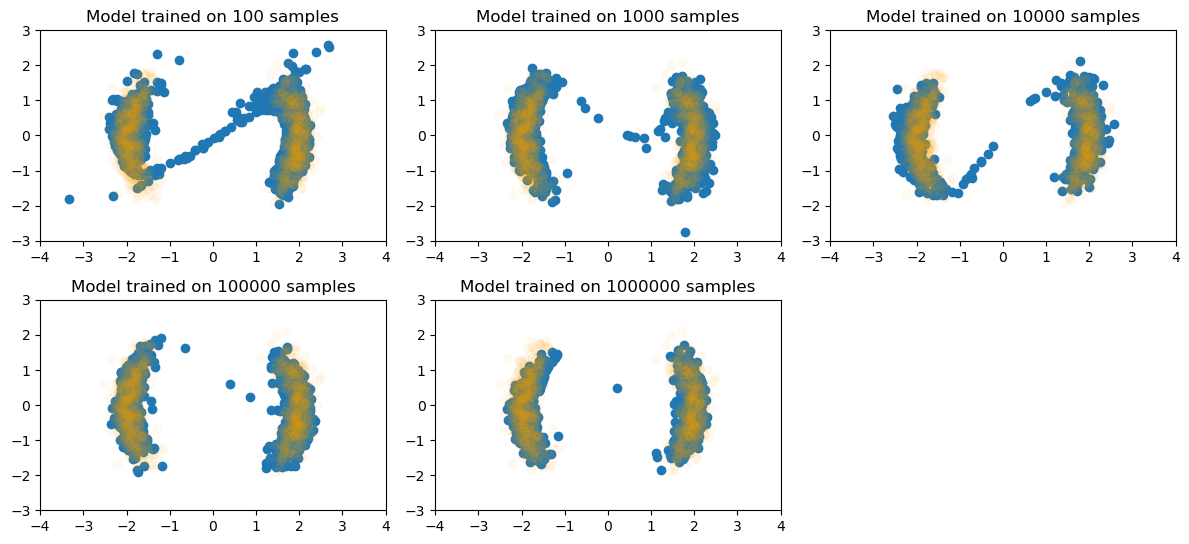

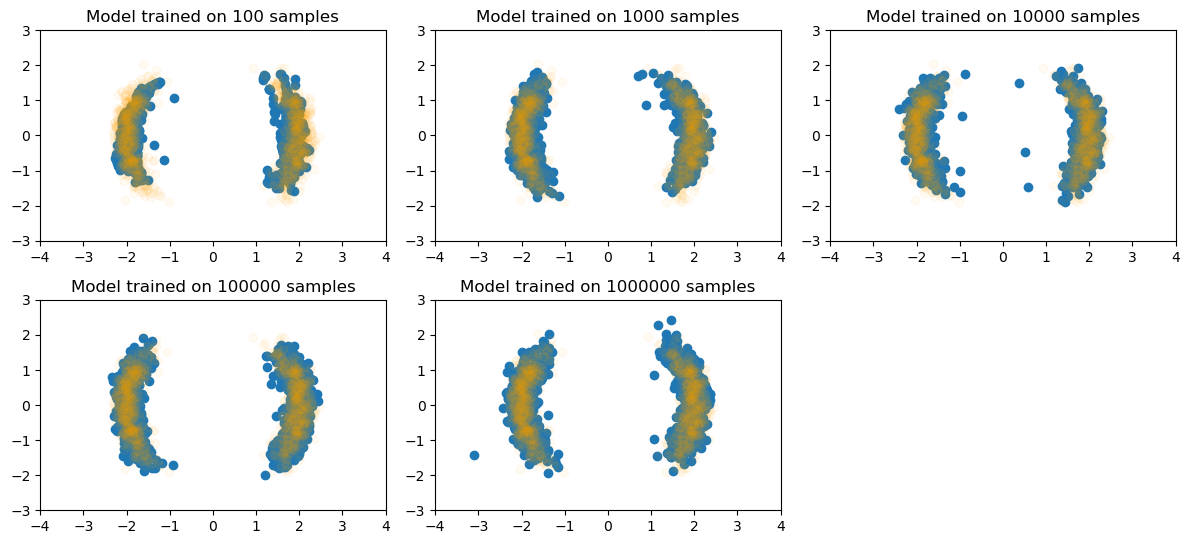

In [ ]:
#vizualizing how each model performs
for models in Models:
        target_samples = target.sample(1000)
        plt.figure(figsize=(12,8))
        with torch.no_grad():
                for i in range(len(models)):
                        k=i+1
                        validation_samples = base.sample(1000).to(device)
                        guesses = torch.Tensor.cpu(models[i](validation_samples))
                        plt.subplot(3,3,k)
                        plt.scatter(guesses[:,0],guesses[:,1])
                        plt.scatter(target_samples[:, 0], target_samples[:, 1], color='orange', alpha=0.05)
                        plt.title(f'Model trained on {sample_numbers[i]} samples')
                        plt.xlim(-4, 4)
                        plt.ylim(-3, 3)
        plt.tight_layout()
        plt.show()

In [ ]:
def KL_calculations(models): #takes in a group of models and returns the KL values
        KL_for_different_models=[]

        x = target.sample(10000).detach().to(device)        
        log_prob_target = target.log_prob(x)

        with torch.no_grad():
                for i in tqdm(range(len(models))):
                                log_prob_model = models[i].log_prob(x)
                                KL_target_model = (log_prob_target - log_prob_model).mean()

                                KL_for_different_models.append(KL_target_model.item())
        return KL_for_different_models

In [ ]:
KL_comparisons=[]

for mods in Models:
    KL_comparisons.append(KL_calculations(mods))

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 66.03it/s]


In [ ]:
print(KL_comparisons)

[[2.566060781478882, 2.427346706390381, 2.432476758956909, 1.0827271938323975, 0.9500222206115723], [2.40798020362854, 0.8991441130638123, 0.8230791687965393, 0.8342887759208679, 0.8353687524795532], [2.6865603923797607, 1.0335222482681274, 1.0373026132583618, 0.9189757704734802, 1.1561139822006226], [2.663426637649536, 0.9369831681251526, 0.9108200669288635, 0.8200917840003967, 0.8133020401000977]]


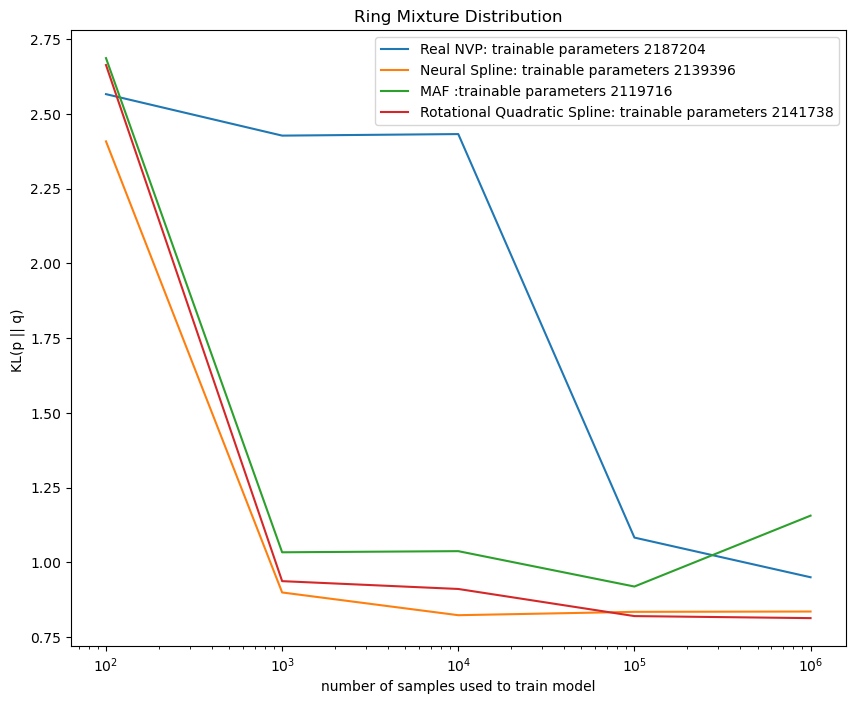

In [ ]:
#plotting to see how KL Divergence values differes with number of samples
plt.figure(figsize=(10,8))
plt.title('Ring Mixture Distribution')
labels = ''
for i in range(len(KL_comparisons)):
    if i == 0:
        labels = f'Real NVP: trainable parameters {trainable_parameters[i]}'
    elif i==1:
        labels = f'Neural Spline: trainable parameters {trainable_parameters[i]}'
    elif i ==2:
        labels = f'MAF :trainable parameters {trainable_parameters[i]}'
    else:
        labels = f"Rotational Quadratic Spline: trainable parameters {trainable_parameters[3]}"

    plt.plot(sample_numbers[:],KL_comparisons[i][:],label=labels)
    plt.xlabel('number of samples used to train model')
    plt.ylabel('KL(p || q) ')
    plt.xscale('log')

    
plt.legend()
plt.show()

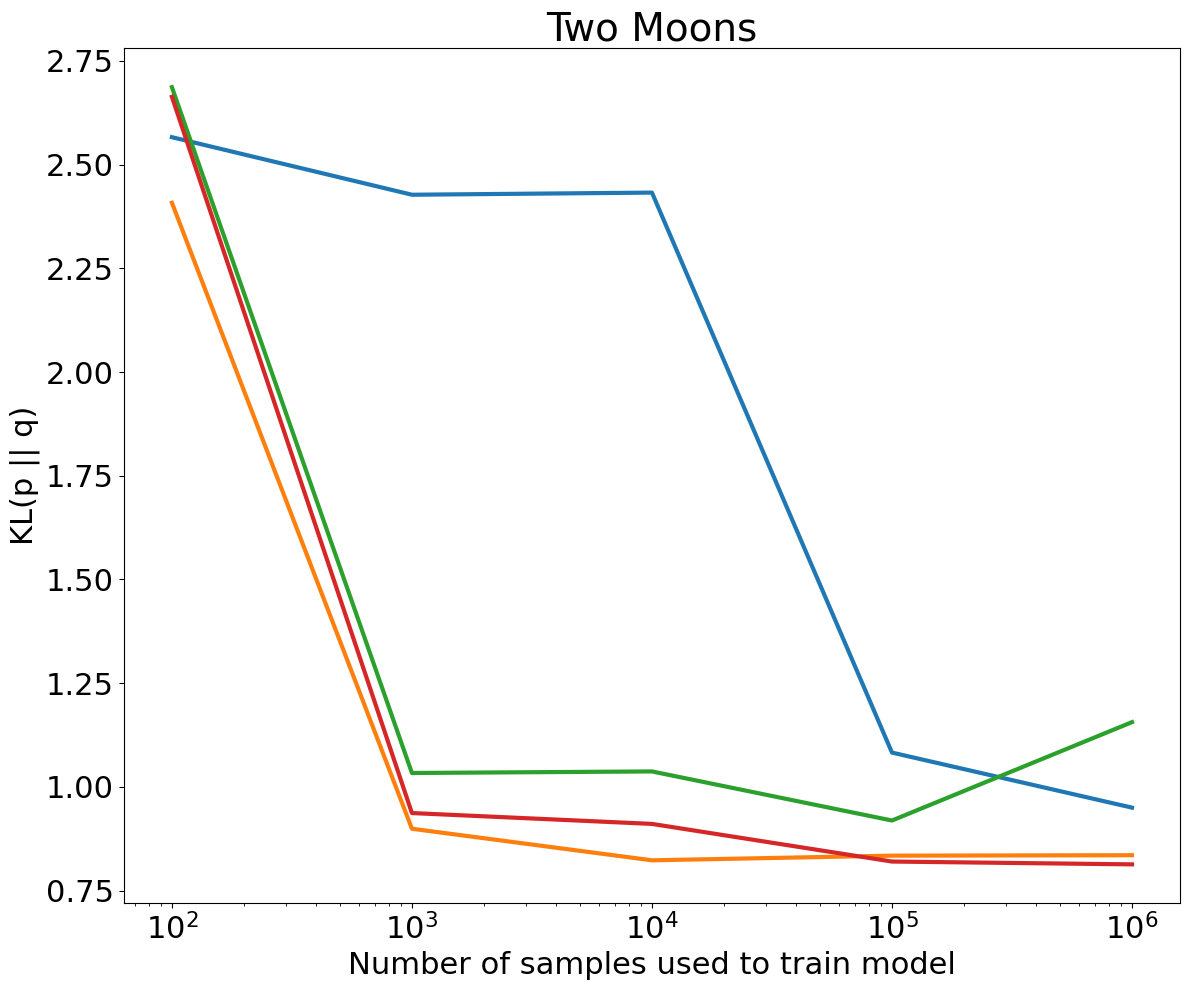

In [ ]:
#plotting to see how KL Divergence values differes with number of samples
plt.figure(figsize=(12,10))
plt.title('Two Moons', fontsize=28)
labels = ''
for i in range(len(KL_comparisons)):
    if i == 0:
        labels = f'Real NVP: trainable parameters {trainable_parameters[i]}'
    elif i==1:
        labels = f'Neural Spline: trainable parameters {trainable_parameters[i]}'
    elif i ==2:
        labels = f'MAF: trainable parameters {trainable_parameters[i]}'
    else:
        labels = f"Rotational Quadratic Spline: trainable parameters {trainable_parameters[3]}"

    plt.plot(sample_numbers[:], KL_comparisons[i][:], label=labels, linewidth=3)

plt.xlabel('Number of samples used to train model', fontsize=22)
plt.ylabel('KL(p || q)', fontsize=22)
plt.xscale('log')

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.tight_layout()
plt.show()